In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from torchsummary import summary
import pandas as pd

In [2]:
transform = transforms.Compose([transforms.ToTensor(),transforms.CenterCrop(28),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [3]:
trainset = torchvision.datasets.CIFAR10(root='./', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./', train=False, transform=transform)


Extracting ./cifar-10-python.tar.gz to ./


In [4]:
trainloader = torch.utils.data.DataLoader(trainset,batch_size=32, shuffle=True, num_workers=2,pin_memory=True)
testloader = torch.utils.data.DataLoader(testset,batch_size=32, shuffle=False, num_workers=2,pin_memory=True)

In [14]:
class ConvModule(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(ConvModule, self).__init__()
        
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.act = nn.ReLU()
        
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.act(x)
        return x
 
class InceptionModule(nn.Module):
    
    def __init__(self, in_channels, f_1x1, f_3x3):
        super(InceptionModule, self).__init__()
        
        self.branch1 = nn.Sequential(
            ConvModule(in_channels, f_1x1, kernel_size=1, stride=1, padding=0)
        )
        
        self.branch2 = nn.Sequential(
            ConvModule(in_channels, f_3x3, kernel_size=3, stride=1, padding=1)
        )
                
    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        return torch.cat([branch1, branch2], 1)


class DownsampleModule(nn.Module):
    def __init__(self, in_channels, f_3x3):
        super(DownsampleModule, self).__init__()
    
        self.branch1 = nn.Sequential(ConvModule(in_channels, f_3x3, kernel_size=3, stride=2, padding=0))
        self.branch2 = nn.MaxPool2d(3, stride=2)
    
    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        return torch.cat([branch1, branch2], 1)
   
class InceptionSmall(nn.Module):
    def __init__(self, num_classes = 10):
        super(InceptionSmall, self).__init__()
        
        self.conv1 = ConvModule(in_channels =3,out_channels=96, kernel_size=3, stride=1, padding=0)
        self.inception1 = InceptionModule(in_channels=96,f_1x1=32,f_3x3=32)
        self.inception2 = InceptionModule(in_channels=64,f_1x1=32,f_3x3=48)
        self.down1 = DownsampleModule(in_channels=80,f_3x3=80)
        self.inception3 = InceptionModule(in_channels=160,f_1x1=112,f_3x3=48)
        self.inception4 = InceptionModule(in_channels=160,f_1x1=96,f_3x3=64)
        self.inception5 = InceptionModule(in_channels=160,f_1x1=80,f_3x3=80)
        self.inception6 = InceptionModule(in_channels=160,f_1x1=48,f_3x3=96)   
        self.down2 = DownsampleModule(in_channels=144,f_3x3=96)
        self.inception7 = InceptionModule(in_channels=240,f_1x1=176,f_3x3=160)
        self.inception8 = InceptionModule(in_channels=336,f_1x1=176,f_3x3=160)
        self.meanpool = nn.AdaptiveAvgPool2d((7,7))
        self.fc = nn.Linear(16464, num_classes)
       
    def forward(self, x):
        x = self.conv1(x)
        x = self.inception1(x)
        x = self.inception2(x)
        x = self.down1(x)
        x = self.inception3(x)
        x = self.inception4(x)
        x = self.inception5(x)
        x = self.inception6(x)
        x = self.down2(x)
        x = self.inception7(x)
        x = self.inception8(x)
        x = self.meanpool(x)
        x = torch.flatten(x,1)
        x = self.fc(x)
        return x

In [6]:
def get_device():
  if torch.cuda.is_available():
      return torch.device('cuda')
  else:
      return torch.device('cpu')
device = get_device()
device

device(type='cuda')

In [8]:
def eval_model(model,trainloader,testloader):
  model.eval()
  correct = 0
  total = 0
  for i, data in enumerate(testloader, 0):
    images, labels = data[0].to(device), data[1].to(device)
    outputs = model(images)
    _, preds = torch.max(outputs, dim=1)
    total += labels.size(0)
    correct += (preds == labels).sum().item()
  acc_v = (correct / total)

  correct = 0
  total = 0            
  for i, data in enumerate(trainloader, 0):
    images, labels = data[0].to(device), data[1].to(device)
    outputs = model(images)
    _, preds = torch.max(outputs, dim=1)
    total += labels.size(0)
    correct += (preds == labels).sum().item()
  acc_t = (correct / total)
  return acc_t,acc_v

def fit(epoch, model, trainloader, testloader, optimizer,scheduler):
  history_t = []
  history_v = []
  step_count = 0
  criterion = nn.CrossEntropyLoss().to(device)
  for epoch in range(epoch):  
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
      inputs, labels = data[0].to(device), data[1].to(device)
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      step_count += 1
      if step_count%1000==0:
        acc_t,acc_v = eval_model(model,trainloader,testloader)
        model.train()
        history_t.append(acc_t)
        history_v.append(acc_v)
        log_ = str(step_count)+","+str(acc_t)+","+str(acc_v)+"\n"
        with open("model.log", "a") as f:
          f.write(log_)
    print("Epoch {} | loss: {:.4f} | Train acc: {:.4f} | Val acc: {:.4f}".format(epoch+1, running_loss,acc_t, acc_v))
    scheduler.step()
  return model,history_t,history_v

In [17]:
net = InceptionSmall().to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.95)
trained_model,history_t1,history_v1 = fit(100, net, trainloader, testloader, optimizer,scheduler)

Epoch 1 | loss: 4000.6874 | Train acc: 0.1000 | Val acc: 0.1001
Epoch 2 | loss: 3362.1550 | Train acc: 0.2220 | Val acc: 0.2272
Epoch 3 | loss: 2944.2078 | Train acc: 0.3054 | Val acc: 0.3046
Epoch 4 | loss: 2689.0804 | Train acc: 0.3742 | Val acc: 0.3709
Epoch 5 | loss: 2488.6883 | Train acc: 0.4275 | Val acc: 0.4254
Epoch 6 | loss: 2299.1116 | Train acc: 0.5020 | Val acc: 0.4883
Epoch 7 | loss: 2116.4169 | Train acc: 0.5233 | Val acc: 0.5055
Epoch 8 | loss: 1925.2790 | Train acc: 0.5967 | Val acc: 0.5815
Epoch 9 | loss: 1781.8259 | Train acc: 0.6311 | Val acc: 0.6060
Epoch 10 | loss: 1665.2522 | Train acc: 0.6049 | Val acc: 0.5740
Epoch 11 | loss: 1549.8891 | Train acc: 0.6624 | Val acc: 0.6300
Epoch 12 | loss: 1455.2056 | Train acc: 0.7035 | Val acc: 0.6593
Epoch 13 | loss: 1359.5569 | Train acc: 0.7297 | Val acc: 0.6777
Epoch 14 | loss: 1268.3331 | Train acc: 0.7047 | Val acc: 0.6552
Epoch 15 | loss: 1185.3405 | Train acc: 0.7616 | Val acc: 0.6920
Epoch 16 | loss: 1102.5043 | Train

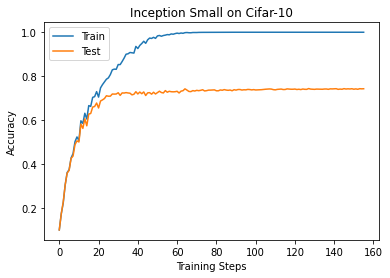

In [18]:
plt.plot(list(history_t1),label='Train')
plt.plot(list(history_v1),label='Test')
plt.xlabel('Training Steps')
plt.ylabel('Accuracy')
plt.title('Inception Small on Cifar-10')
plt.legend()
plt.show()

Without Batch Normalization

In [7]:
class ConvModule(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(ConvModule, self).__init__()
        
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.act = nn.ReLU()
        
    def forward(self, x):
        x = self.conv(x)
        x = self.act(x)
        return x
 
class InceptionModule(nn.Module):
    
    def __init__(self, in_channels, f_1x1, f_3x3):
        super(InceptionModule, self).__init__()
        
        self.branch1 = nn.Sequential(
            ConvModule(in_channels, f_1x1, kernel_size=1, stride=1, padding=0)
        )
        
        self.branch2 = nn.Sequential(
            ConvModule(in_channels, f_3x3, kernel_size=3, stride=1, padding=1)
        )
                
    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        return torch.cat([branch1, branch2], 1)


class DownsampleModule(nn.Module):
    def __init__(self, in_channels, f_3x3):
        super(DownsampleModule, self).__init__()
    
        self.branch1 = nn.Sequential(ConvModule(in_channels, f_3x3, kernel_size=3, stride=2, padding=0))
        self.branch2 = nn.MaxPool2d(3, stride=2)
    
    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        return torch.cat([branch1, branch2], 1)

class InceptionSmall2(nn.Module):
    def __init__(self, num_classes = 10):
        super(InceptionSmall2, self).__init__()
        
        self.conv1 = ConvModule(in_channels =3,out_channels=96, kernel_size=3, stride=1, padding=0)
        self.inception1 = InceptionModule(in_channels=96,f_1x1=32,f_3x3=32)
        self.inception2 = InceptionModule(in_channels=64,f_1x1=32,f_3x3=48)
        self.down1 = DownsampleModule(in_channels=80,f_3x3=80)
        self.inception3 = InceptionModule(in_channels=160,f_1x1=112,f_3x3=48)
        self.inception4 = InceptionModule(in_channels=160,f_1x1=96,f_3x3=64)
        self.inception5 = InceptionModule(in_channels=160,f_1x1=80,f_3x3=80)
        self.inception6 = InceptionModule(in_channels=160,f_1x1=48,f_3x3=96)   
        self.down2 = DownsampleModule(in_channels=144,f_3x3=96)
        self.inception7 = InceptionModule(in_channels=240,f_1x1=176,f_3x3=160)
        self.inception8 = InceptionModule(in_channels=336,f_1x1=176,f_3x3=160)
        self.meanpool = nn.AdaptiveAvgPool2d((7,7))
        self.fc = nn.Linear(16464, num_classes)
       
    def forward(self, x):
        x = self.conv1(x)
        x = self.inception1(x)
        x = self.inception2(x)
        x = self.down1(x)
        x = self.inception3(x)
        x = self.inception4(x)
        x = self.inception5(x)
        x = self.inception6(x)
        x = self.down2(x)
        x = self.inception7(x)
        x = self.inception8(x)
        x = self.meanpool(x)
        x = torch.flatten(x,1)
        x = self.fc(x)
        return x

In [10]:
net = InceptionSmall2().to(device)
optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 100, gamma=1.0)
trained_model2,history_t2,history_v2 = fit(50, net, trainloader, testloader, optimizer,scheduler)

Epoch 1 | loss: 3600.0638 | Train acc: 0.1000 | Val acc: 0.1000
Epoch 2 | loss: 3599.5477 | Train acc: 0.1000 | Val acc: 0.1000
Epoch 3 | loss: 3599.5158 | Train acc: 0.1000 | Val acc: 0.1000
Epoch 4 | loss: 3599.4431 | Train acc: 0.1000 | Val acc: 0.1000
Epoch 5 | loss: 3599.3711 | Train acc: 0.1000 | Val acc: 0.1000
Epoch 6 | loss: 3599.2670 | Train acc: 0.1000 | Val acc: 0.1000
Epoch 7 | loss: 3599.1976 | Train acc: 0.1000 | Val acc: 0.1000
Epoch 8 | loss: 3599.1291 | Train acc: 0.1000 | Val acc: 0.1000
Epoch 9 | loss: 3599.1957 | Train acc: 0.1000 | Val acc: 0.1000
Epoch 10 | loss: 3599.0599 | Train acc: 0.1000 | Val acc: 0.1000
Epoch 11 | loss: 3598.9738 | Train acc: 0.1000 | Val acc: 0.1000
Epoch 12 | loss: 3598.6439 | Train acc: 0.1427 | Val acc: 0.1442
Epoch 13 | loss: 3582.8356 | Train acc: 0.1736 | Val acc: 0.1744
Epoch 14 | loss: 3061.0582 | Train acc: 0.2550 | Val acc: 0.2541
Epoch 15 | loss: 2835.2798 | Train acc: 0.3065 | Val acc: 0.2998
Epoch 16 | loss: 2626.7940 | Train

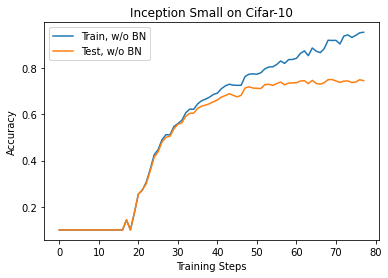

In [11]:
plt.plot(list(history_t2),label='Train, w/o BN')
plt.plot(list(history_v2),label='Test, w/o BN')
plt.xlabel('Training Steps')
plt.ylabel('Accuracy')
plt.title('Inception Small on Cifar-10')
plt.legend()
plt.show()

In [12]:
trained_model2,history_t21,history_v21 = fit(50, trained_model2, trainloader, testloader, optimizer,scheduler)

Epoch 1 | loss: 255.7403 | Train acc: 0.9385 | Val acc: 0.7313
Epoch 2 | loss: 233.6752 | Train acc: 0.9692 | Val acc: 0.7394
Epoch 3 | loss: 216.0887 | Train acc: 0.9398 | Val acc: 0.7337
Epoch 4 | loss: 189.0141 | Train acc: 0.9593 | Val acc: 0.7400
Epoch 5 | loss: 171.8858 | Train acc: 0.9661 | Val acc: 0.7384
Epoch 6 | loss: 153.8803 | Train acc: 0.9772 | Val acc: 0.7435
Epoch 7 | loss: 153.5369 | Train acc: 0.9784 | Val acc: 0.7398
Epoch 8 | loss: 122.5132 | Train acc: 0.9756 | Val acc: 0.7427
Epoch 9 | loss: 129.9031 | Train acc: 0.9843 | Val acc: 0.7475
Epoch 10 | loss: 118.3773 | Train acc: 0.9761 | Val acc: 0.7383
Epoch 11 | loss: 97.0737 | Train acc: 0.9872 | Val acc: 0.7468
Epoch 12 | loss: 99.4071 | Train acc: 0.9829 | Val acc: 0.7428
Epoch 13 | loss: 88.7162 | Train acc: 0.9866 | Val acc: 0.7471
Epoch 14 | loss: 81.6269 | Train acc: 0.9897 | Val acc: 0.7462
Epoch 15 | loss: 78.2803 | Train acc: 0.9729 | Val acc: 0.7361
Epoch 16 | loss: 87.4924 | Train acc: 0.9788 | Val acc

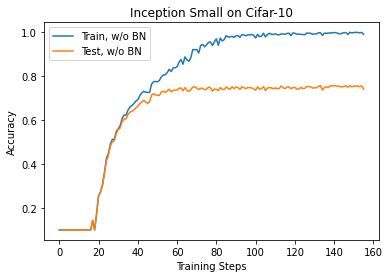

In [13]:
plt.plot(list(history_t2+history_t21),label='Train, w/o BN')
plt.plot(list(history_v2+history_v21),label='Test, w/o BN')
plt.xlabel('Training Steps')
plt.ylabel('Accuracy')
plt.title('Inception Small on Cifar-10')
plt.legend()
plt.show()

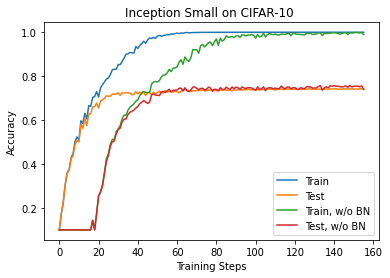

In [19]:
plt.plot(list(history_t1),label='Train')
plt.plot(list(history_v1),label='Test')
plt.plot(list(history_t2+history_t21),label='Train, w/o BN')
plt.plot(list(history_v2+history_v21),label='Test, w/o BN')
plt.xlabel('Training Steps')
plt.ylabel('Accuracy')
plt.title('Inception Small on CIFAR-10 ')
plt.legend()
plt.show()